# Práctica 2 - Juan Sevilla Fernández

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import yfinance as yf
import statsmodels.formula.api as smf
import statsmodels.api as sm
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sktime.transformations.series.boxcox import LogTransformer
from sktime.utils.plotting import plot_correlations
from sktime.utils.plotting import plot_series
from sktime.transformations.series.difference import Differencer

# Introduccion: 
<br>
En esta práctica entrenaremos dos modelos para, por un lado poder predecir los precios de cierre de las accione de BMW y VW; y por otro lado, predecir la volatilidad de los benfeicios diarios de BMW. 
<br>
Para la realizacion de esta practica utilizare el paquete yfinance para descargar el historico de precios de cierre diarios de ambas compañias.
<br>
1. Para el primer modelo, entrenaremos un VAR enre los valores de cierre de cada mes de BMW y VW, para ver si el precio de uno se puede explicar en base a su precio en t-n meses y el precio de la otra compañia en el pasado.
<br>
2. Para el segundo modelo, busco entrenar un GARCH que sea capaz de predecirme la volatilidad de los retornos de BMW en el futuro

In [2]:
dataBMW = yf.download("BMW.DE", start="2008-12-31", end="2020-10-31", progress=False)[['Adj Close']]
dataBMW_test = yf.download("BMW.DE", start="2020-11-1", end="2021-10-31", progress=False)[['Adj Close']]
dataVW = yf.download("VOW.DE", start="2008-12-31", end="2020-10-31", progress=False)[['Adj Close']]
dataVW_test = yf.download("VOW.DE", start="2020-11-1", end="2021-10-31", progress=False)[['Adj Close']];

In [3]:
dataBMW = dataBMW.resample("M").last()
dataBMW_test = dataBMW_test.resample("M").last()
dataVW = dataVW.resample("M").last()
dataVW_test = dataVW_test.resample("M").last()

# 1. Estima un modelo VAR mensual entre los dos activos. (Muestra:2009/01 a 2020/10)

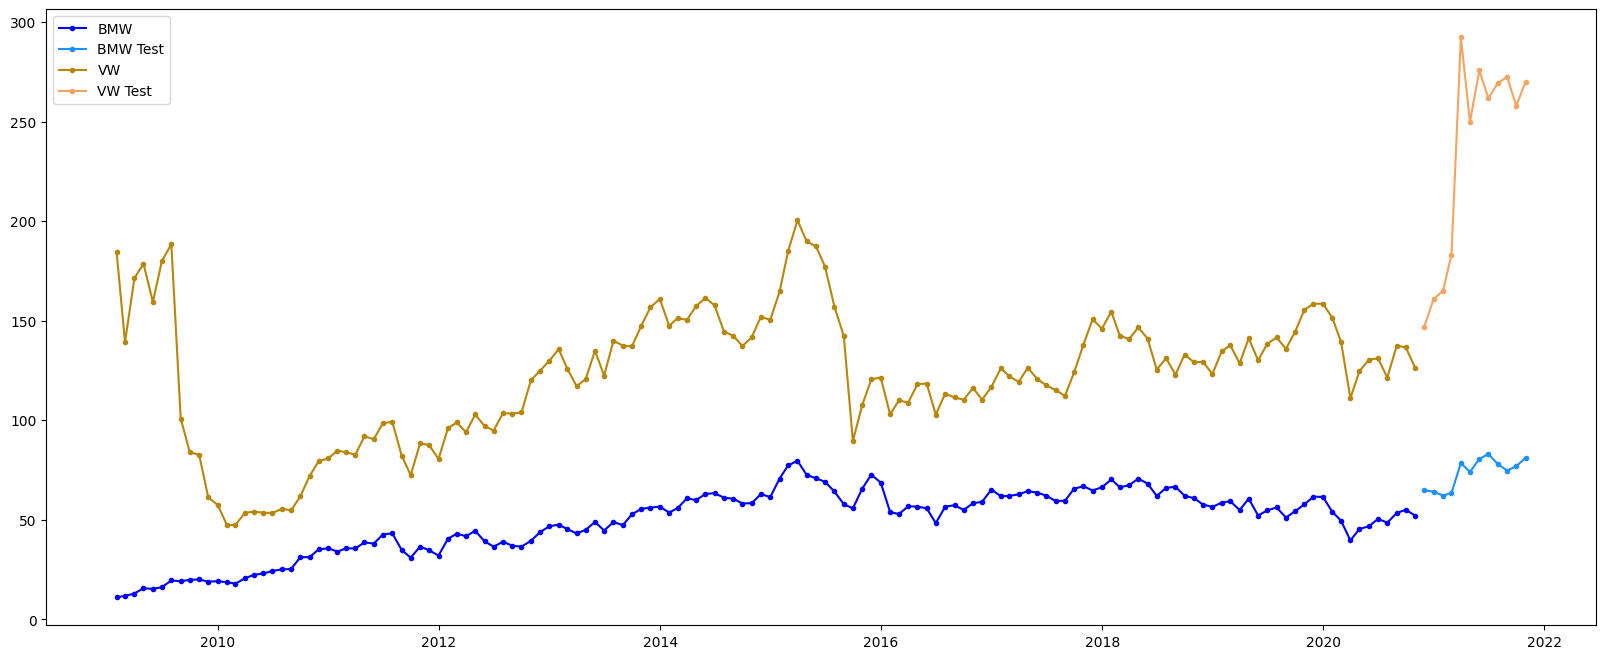

In [4]:
plt.figure(figsize=(20, 8))
plt.plot(dataBMW,"blue", label = "BMW", marker = ".")
plt.plot(dataBMW_test, "dodgerblue", label = "BMW Test", marker = ".")
plt.plot(dataVW, "darkgoldenrod", label = "VW", marker = ".")
plt.plot(dataVW_test, "sandybrown", label = "VW Test", marker = ".")
plt.legend(loc="upper left");

Para estimar el modelo VAR tomamos la muestra de precios de cierre de BMW y VW desde enero de 2009 hasta octubre de 2020. Esta muestra la tomaremos ara entrenar nuestro modelo. A continuacion estimare el precio hasta octubre de 2021 que contrastare con los datos que se ven en el grafico como valores de test.<br>
En este grafico podemos observar difrentes reacciones del precio a eventos historicos. Por un lado, tenemos a finales de 2015 el "dieselgate" de VW. Que se puede observar como este escandalo no solo desploa el valor de la accion de VW, si no que tambien parece tener un impacto negativo sobre BMW. Por otro lado se puede aprciar en 2020 el fecto del covid en ambas compañias. <br>
Sin embargo, tambien hay shocks en nuestro conjunto de test, ya que justo a principios de 2021, en especial VW, disfrutaron una subida de demanda tras sus favorables comparaciones de vehiculos electricos con Tesla.

In [5]:
leadBMW = pd.DataFrame()
leadBMW["BMW"] = dataBMW
leadBMW["VW"] = dataVW

leadVW = leadBMW[leadBMW.columns[::-1]]

In [6]:
d_leadBMW = leadBMW.diff().dropna()
d_leadVW = d_leadBMW[d_leadBMW.columns[::-1]]

## Autocorrelaciones simples y parciales de beneficios de BMW

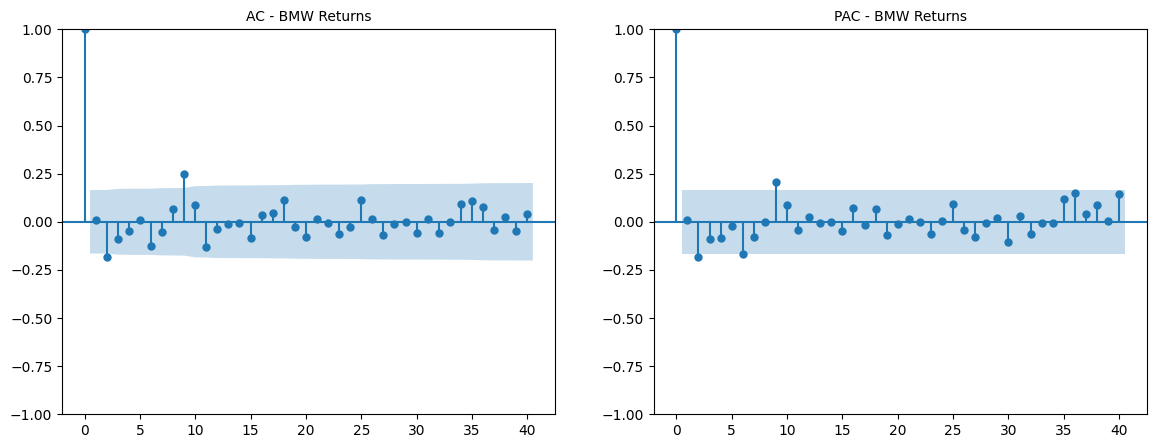

In [7]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
plot_acf(d_leadBMW['BMW'], lags=40, ax=ax1)
ax1.set_title('AC - BMW Returns', fontsize=10)
plot_pacf(d_leadBMW['BMW'], lags=40, method='ywm', ax=ax2)
ax2.set_title('PAC - BMW Returns', fontsize=10)
plt.show()
plt.close()

## Autocorrelaciones simples y parciales de beneficios de VW

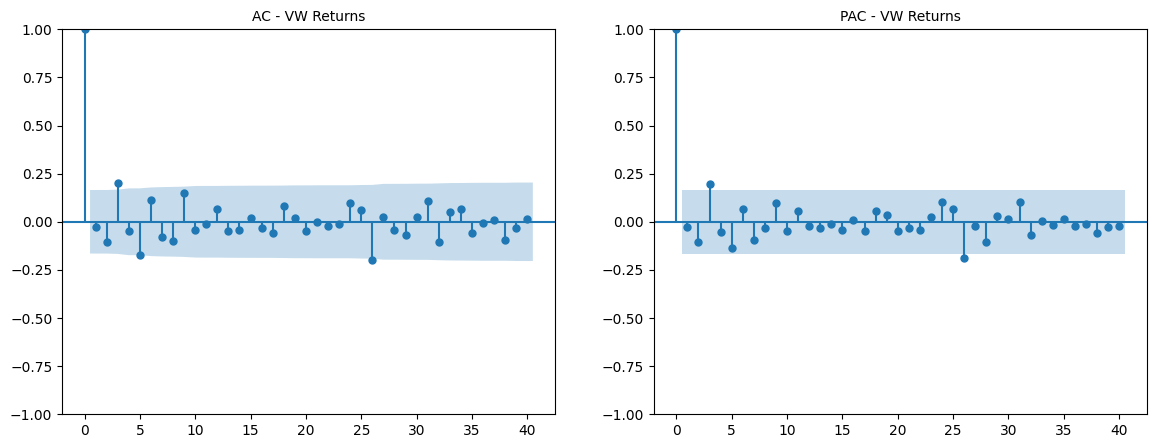

In [8]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
plot_acf(d_leadBMW['VW'], lags=40, ax=ax1)
ax1.set_title('AC - VW Returns', fontsize=10)
plot_pacf(d_leadBMW['VW'], lags=40, method='ywm', ax=ax2)
ax2.set_title('PAC - VW Returns', fontsize=10)
plt.show()
plt.close()

Despues de ver las autocorrelaciones simples y parciales de los residuos de los beneicios de BMW y VW vemos como apenas hay autoccerralcion significativa. Es por esto, que para prdecir los precios de una compañía necesitemos apoyarnos en los precios pasados de la otra para obtener capacidad predictiva. <br><br>

# 2. ¿Cuál es la predicción para octubre de 2021 de los dos activos? ¿Son buenas predicciones?

Para predecir el valor de ambos activos, entrenamos un modelo VAR en base a los beneficios entre precios de cierre mes a mes y predecimos resultado para el mes de octubre 2021. Estos los contrastaremos con los vlores reales de test

In [9]:
model = VAR(d_leadBMW)
model.select_order(30);
results = model.fit(maxlags=30, ic='aic')

In [10]:
f_data=leadBMW.values[-1:]+results.forecast(d_leadBMW.values[-results.k_ar:], 12)

In [11]:
data_fore=pd.DataFrame(f_data)
data_fore.index=dataBMW_test.index
data_fore.rename(columns={0: 'f_BMW', 1: 'f_VW'}, inplace=True)

## Predicciones BMW

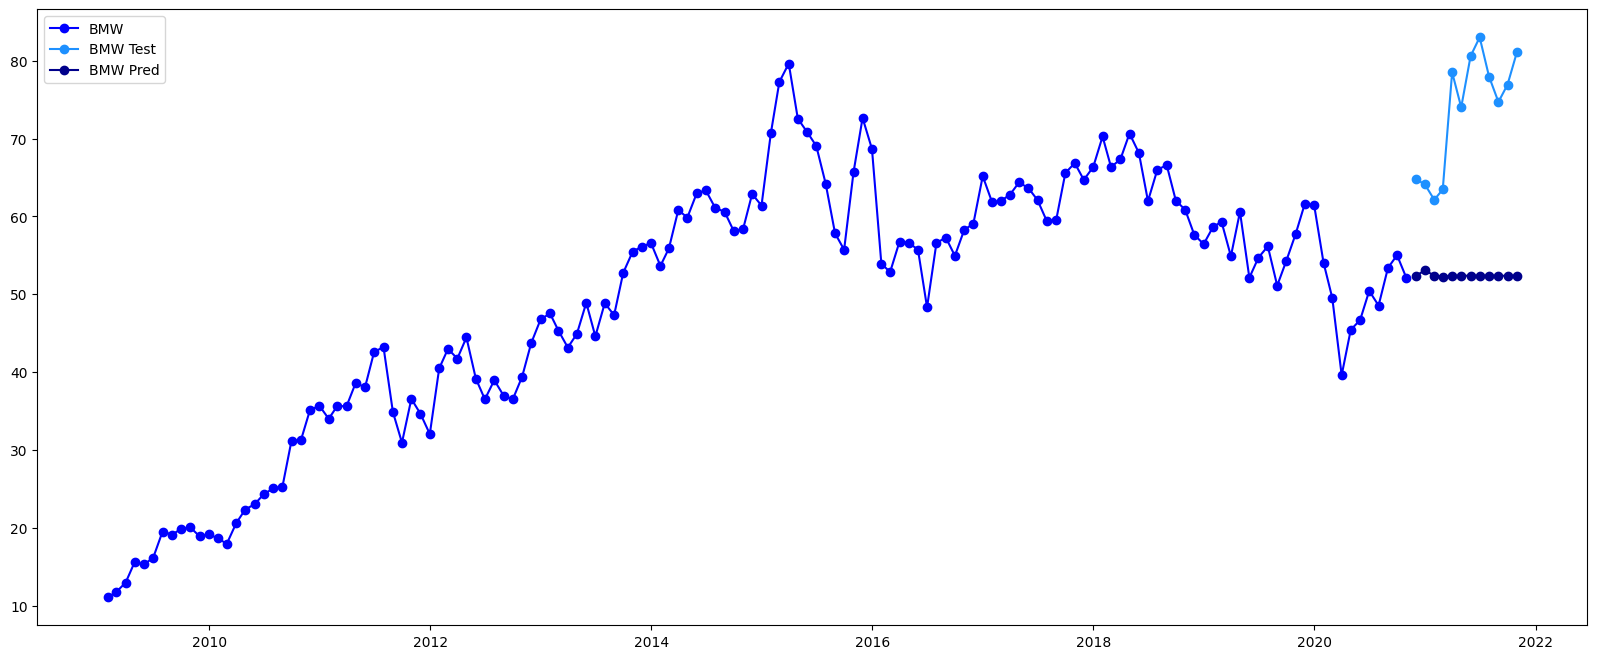

In [12]:
plt.figure(figsize=(20, 8))
plt.plot(dataBMW,"blue", label = "BMW", marker = "o")
plt.plot(dataBMW_test, "dodgerblue", label = "BMW Test", marker = "o")
plt.plot(data_fore["f_BMW"], "darkblue", label = "BMW Pred", marker = "o")
plt.legend(loc="upper left");

## Predicciones VW

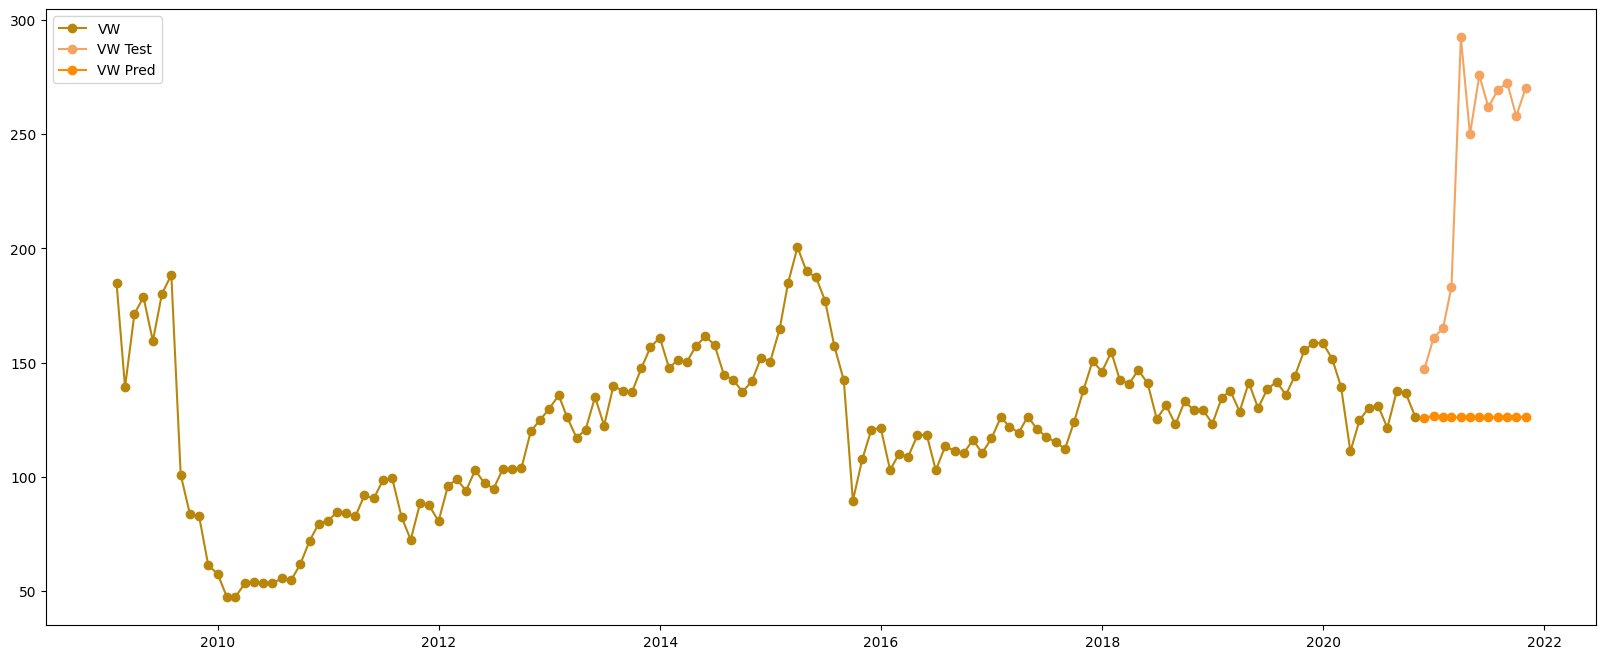

In [13]:
plt.figure(figsize=(20, 8))
plt.plot(dataVW,"darkgoldenrod", label = "VW", marker = "o")
plt.plot(dataVW_test, "sandybrown", label = "VW Test", marker = "o")
plt.plot(data_fore["f_VW"], "darkorange", label = "VW Pred", marker = "o")
plt.legend(loc="upper left");

Las predicciones para ambos precios son poco precisas. A pesar de que esperaramos que no se pudiera predcir tal shock positivo en los precios de las acciones, el modelo VAR no es capaz si quiera de predecir la tendencia ya que la mantiene constante durante todo el año. Esto significa que usar un modelo VAR, que toma retardos de la variable y de otras vaibales en el sistema para realizar las predicciones no es adecuado para estas variables.

De todos modos, la predicción de los precios de ambas compañías para octubre de 2021 es de 52,37 y 126.00 para BMW y Volkswagen respectivamente, pero como se puede observar en los gráficos, la predicción se aleja mcuho de la realidad. 

Esto es algo de esperar,  ya que lo que estamos intentando ver es si el precio de cierre de BMW o VW en un mes t se puede predecir via el precio en t-n meses de ambas compañías.
Para mí, este análisis sería correcto si estamos hablando de horas o minutos, pero basarnos en precios de cierre de hace n meses no tiene mucho sentido a la hora de predecir precios de acciones, ya que estos se actualizan de forma continua cada vez que sale una nueva noticia.

Es por esto que pienso que para poder mejorar el modelo, propondrían dos cursos de accion:
1. Introducir variables macroeconomicas, índices de mercado y/o alguna de sentimiento del mercado, ya que estasi que creo que serian lideres mes a mes sobre los precios de las acciones. (si hay sentimiento malo, alta inflacion/tipos de interes o si todo el mercado esta bajista, segurmente BMW o VW tambien sufran en meses posteriores).

2. Realizar el mismo modelo var, pero para predecir el precio del dia siguiente de forma "rolling". Es decir, en vez de predecir a un año vista, predecir a un dia y que cada dia use el precio de cierre de ese dia para ajustar el modelo. A esto se le podria añadir como comentava antes una mayor granularidad de datos ya como hacerlos por dias o por horas que es lo que tarda una noticia en afectar al precio de una accion y no meses.

De todos modos, podemos concluir que las predicciones que realizar el modelo VAR no son nada buenas.

# 3. ¿Cuál de los dos activos es el lider y cual es el seguidor?
Despues de entrenar y predecir los resultados del modelo VAR, vemos que...

In [14]:
print('...el número óptimo de retardos es de ' , results.k_ar)

...el número óptimo de retardos es de  2


Era de esperar que que obtuvieramos un numero muy bajo de retardos ya que el precio de una accion se actualiza de forma muy rapida como hemos visto en las predicciones, por lo que en ningun caso observaremos una gran separacion entre lider y seguidor. <br>
Para ver que precio considerar lider y que precio considerar seguidor, realizaos un test de Granger para cada combinacion:

In [15]:
print("Si BMW es lider y VW seguidor, el test de Granger para dos retardos es: ")
gc_res = grangercausalitytests(d_leadBMW, 2)

Si BMW es lider y VW seguidor, el test de Granger para dos retardos es: 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6458  , p=0.2017  , df_denom=137, df_num=1
ssr based chi2 test:   chi2=1.6818  , p=0.1947  , df=1
likelihood ratio test: chi2=1.6718  , p=0.1960  , df=1
parameter F test:         F=1.6458  , p=0.2017  , df_denom=137, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1497  , p=0.3198  , df_denom=134, df_num=2
ssr based chi2 test:   chi2=2.3852  , p=0.3034  , df=2
likelihood ratio test: chi2=2.3650  , p=0.3065  , df=2
parameter F test:         F=1.1497  , p=0.3198  , df_denom=134, df_num=2


In [16]:
print("Si VW es lider y BMWW seguidor, el test de Granger para dos retardos es: ")
gc_res = grangercausalitytests(d_leadVW, 2)

Si VW es lider y BMWW seguidor, el test de Granger para dos retardos es: 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1163  , p=0.2926  , df_denom=137, df_num=1
ssr based chi2 test:   chi2=1.1407  , p=0.2855  , df=1
likelihood ratio test: chi2=1.1361  , p=0.2865  , df=1
parameter F test:         F=1.1163  , p=0.2926  , df_denom=137, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3506  , p=0.7049  , df_denom=134, df_num=2
ssr based chi2 test:   chi2=0.7274  , p=0.6951  , df=2
likelihood ratio test: chi2=0.7255  , p=0.6958  , df=2
parameter F test:         F=0.3506  , p=0.7049  , df_denom=134, df_num=2


Tras analizar ambos resultados, llegamos a la conclusion que ninguno de los tests sugiere que haya causalidad significativa, ya que en ningun caso el p-valor es menor a 0.05. Sin embargo, para el proposito de seguir con este modelo, vamos a considerar a BMW lider ya que el p-valor de esta combinacion es menos de la mitad que en el caso contrario.<br>
Para mejorar nuestro test de Granger, podriamos ver si en vez de que una accion sea lider, ver si un indicador de mercado o variable macro so mejores lideres de estas dos variables como se ha comentado en el ejercicio anterior.

# 4. ¿Es la Volatilidad de BMW constante? Estimar el modelo garch de BMW (Muestra: Toda la disponible en Yahoo hasta el 31/10/2020)

Para realizar este analisis tomamos los valores de cierre de cada dia de la muestra y tomamos la primera diferencia para graficar los beneficios diarios:

In [2]:
dataBMWall = yf.download("BMW.DE", end="2020-11-30", progress=False)[['Adj Close']].rename(columns={'Adj Close': 'Price'})


In [3]:
dataBMWall['log_ret'] =np.log(dataBMWall.Price).diff()
dataBMWall['Squared'] =dataBMWall['log_ret']**2

dataBMW = dataBMWall[:"2020-10-31"]

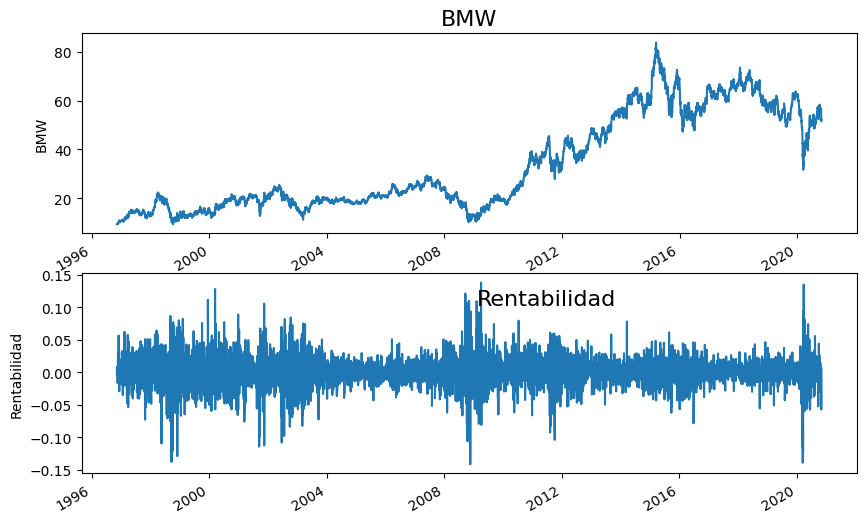

In [4]:
fig = plt.figure(figsize=(10,10))
plt.subplot(311)
ax=dataBMW.Price.plot( linestyle='-')
ax.set_ylabel('BMW')
ax.set_xlabel('')
ax.set_title('BMW', y=1, fontsize = 16)
plt.subplot(312)
ax=dataBMW.log_ret.plot( linestyle='-')
ax.set_ylabel('Rentabilidad')
ax.set_xlabel('')
ax.set_title('Rentabilidad', y=0.8, x=0.6,fontsize = 16);

In [5]:
# mean zero test
from scipy import stats
alpha=0.05
t, p = stats.ttest_1samp(dataBMW['log_ret'].dropna(),0.0)
print("Para la media de rentabilidades de BMW obtenemos que:")
print ('Estadítico t:', round(t,3))
print ('p-value:', round(p,3))

if  p < alpha:
    print (f'Con {alpha} de significación: Rechazamos la hipotesis de media cero.')
else:
    print (f'Con {alpha} de significación: No podemos rechazar la hipotesis de media cero.')

Para la media de rentabilidades de BMW obtenemos que:
Estadítico t: 1.006
p-value: 0.314
Con 0.05 de significación: No podemos rechazar la hipotesis de media cero.


Es decir, la media de las rentabilidades es relatiamente constante en torno a cero. Las rentabilidades tienden a regresar a la media. De este modo observaremos como se comporta la volatilidad de los precios (la rentabilidad al cuadrado) 

## ACF y PACF de los beneficios diarios de BMW al cuadrado (volatilidad)

In [6]:
BMW_vol=dataBMW['Squared'].astype('float64').to_period('D').sort_index().dropna()

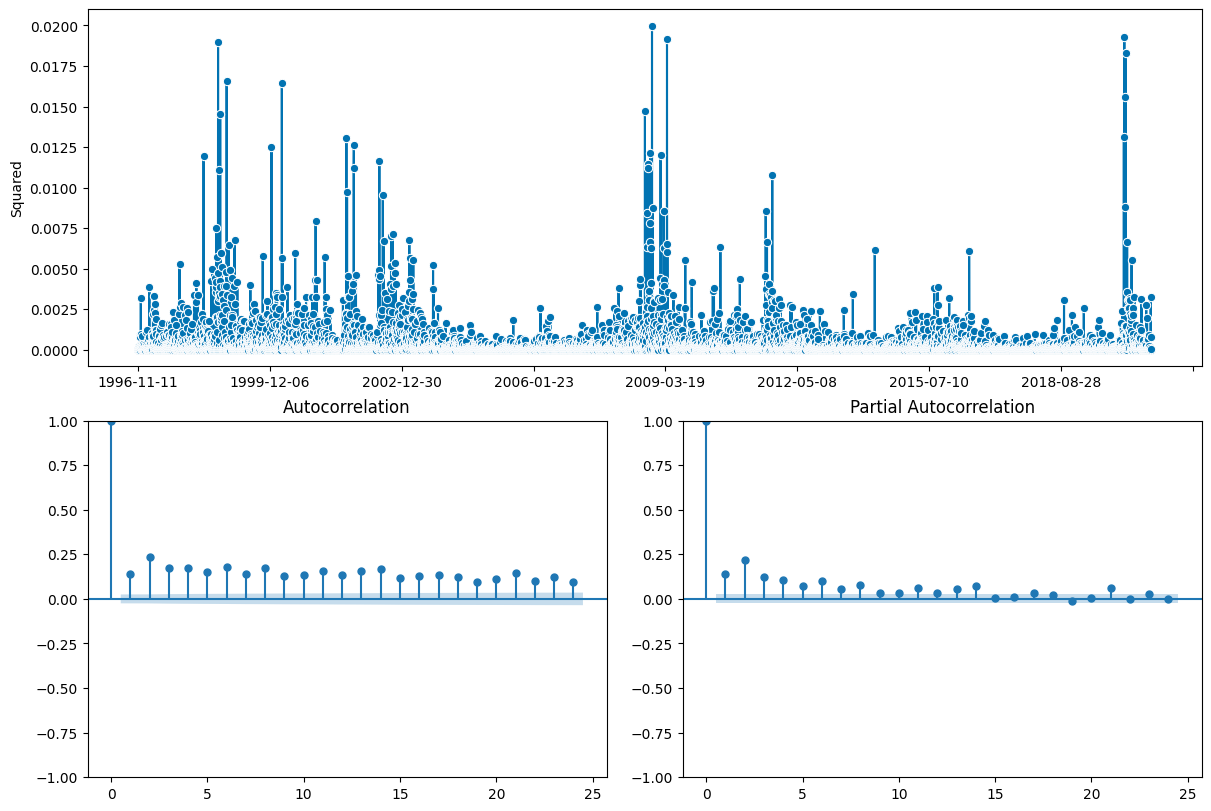

In [7]:
plot_correlations(BMW_vol);

In [8]:
alpha=0.05
t, p = stats.ttest_1samp(dataBMW['Squared'].dropna(),0.0)
print("Para la media de rentabilidades de BMW obtenemos que:")
print ('Estadítico t:', round(t,3))
print ('p-value:', round(p,3))

if  p < alpha:
    print (f'Con {alpha} de significación: Rechazamos la hipotesis de media cero.')
else:
    print (f'Con {alpha} de significación: No podemos rechazar la hipotesis de media cero.')

Para la media de rentabilidades de BMW obtenemos que:
Estadítico t: 30.556
p-value: 0.0
Con 0.05 de significación: Rechazamos la hipotesis de media cero.


Tras graficar las autocorrelaciones de la volatilidad de los pecios de BMW observamos visualmente que existe autocorrelacion entre residuos ya que los indicadores se extienden fuera del area azul. Esto indica que volatilidades pasadas pueden explicar la volatilidad actual. Ademas, la media de la volatilidad no es cero a diferencica de las rentabilidades diarias.

## Test Ljung-Box de los beneficios diarios de BMW al cuadrado (volatilidad).

In [9]:
import statsmodels.api as sm
test_Ljung_Box=sm.stats.acorr_ljungbox
test_Ljung_Box(BMW_vol, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,123.205285,1.257423e-28
2,457.079926,5.576416e-100
3,637.727820,6.669612e-138
4,824.967955,2.998771e-177
5,960.600189,2.033798e-205
6,1160.288345,1.879863e-247
7,1282.237634,1.156378e-272
8,1460.956241,3.731112e-310
9,1562.559255,0.000000e+00
10,1672.968346,0.000000e+00


Para 10 retardos y menos, el p-valor del test de Ljung es menor a 0.05. Esto significa que rechazamos que no haya autocerrlacion entre residuos, lo que rspalda la visualizacion anterior de autocorrelaciones.

## Test de Langrage de Engle (LM)

In [10]:
test_LM_ARCH=sm.stats.diagnostic.het_arch
lm, lmpval, f, pval, result_int =test_LM_ARCH(dataBMW['Squared'].dropna(), nlags=10, store=True)
print ('Estadístico LM: ', lm)
print ('p-value: ', lmpval)
print ('Estadístico F: ', f)
print ('p-value: ', pval)

Estadístico LM:  301.57778977753077
p-value:  7.212367638774238e-59
Estadístico F:  31.65898626486843
p-value:  2.0555484214993415e-60


Los p-valores del test de Langrage de Engle sugieren rechazar la hipotesis nula de que no se pueden explicar las volatilidades mediante un modelo GARCH, por lo que procedemos con este modelo.

## Entrenamiento y predicciones GARCH

Para simplificar el modelo, voy a utilizar un GARCH(1,1) que suele ser el mas comun. Ademas, como hemos visto en el modelo anterior, predicciones para valores de acciones tienen que ser mu a cort plazo debido a su rapidez a la hora de actualizarse el precio segun se anuncian noticias que afecten al precio.

In [11]:
from arch.univariate import ARX
from arch.univariate import ARCH, GARCH
from arch.univariate import StudentsT

In [12]:
ar = ARX(100*dataBMW['log_ret'].dropna(), lags=1)
ar.volatility = GARCH(p=1,q=1)
ar.distribution = StudentsT()
res = ar.fit(update_freq=0, disp="off")

In [13]:
# Análisis Residuos
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

### Eleccion de distribucion para el modelo GARCH

Con una distribucion Normal, el QQplot es:


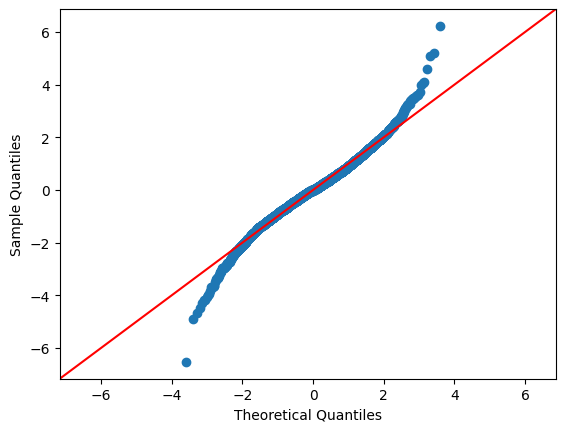

In [14]:
print("Con una distribucion Normal, el QQplot es:")
sm.qqplot(mod1_std_resid,fit=True,line='45')
plt.show()

Con una distribucion t-Student, el QQplot es:


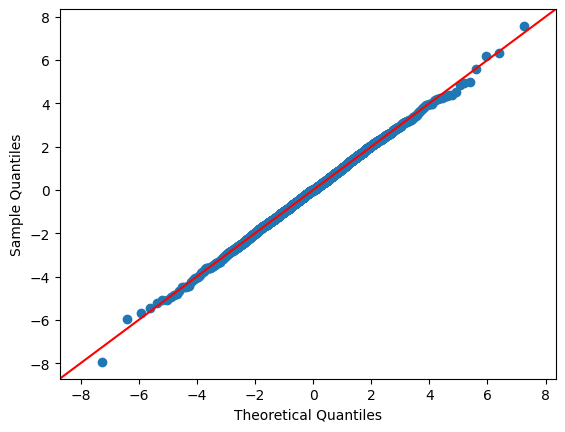

In [15]:
print("Con una distribucion t-Student, el QQplot es:")
sm.qqplot(mod1_std_resid, dist=stats.t ,fit=True,line='45')
plt.show()

Con la ayuda de los QQplots, podemos elegir la distibucion para nuestro modelo GARCH. Vemos que para una distribucion Normal, las colas no estan compensadas con sus quantiles teoricos, esto queire decir que nuestros dtos tienen colas anachas. Por eso, elegimos la distribucion t-Student, que como se puede ver ajusta mejor los quantiles de la muestra a los teoricos. Es por esto que nos quedamos con esta distribucion para entrenar nuestro modelo.

### Resultados modelo GARCH(1,1) + t-Student

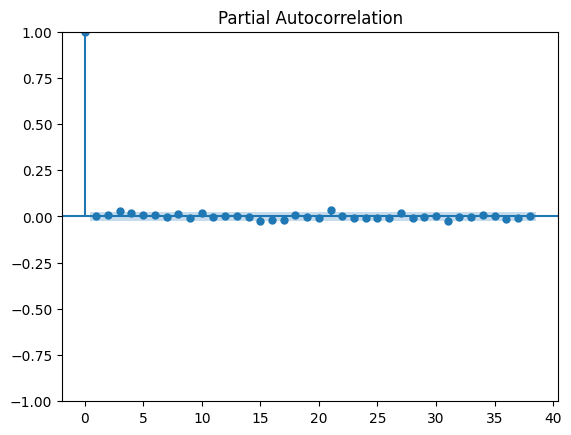

In [16]:
# Plot Autocorrelation
plot_pacf(mod1_std_resid**2, method="yw");

Segun el diagrama autocorrelaciones parciales de residuos, no hay autocorrelacion tras entrenar este modelo. Esto quiere decir que los errores son ruido blanco y el modelo ha sacado toda la informacion predictiva posible.

# 5. ¿Cuál es la predicción para el mes de noviembre de 2020? ¿Son buenas predicciones?

Si graficamos directamente las volatilidades de noviembre 2020 obtenemos lo siguiente:

In [17]:
forecasts = res.forecast(horizon=30, reindex=False)

In [18]:
# Mean
fordf = pd.DataFrame()
fordf["mean"] = forecasts.mean.transpose()
fordf["variance"] = ((forecasts.variance**0.5)*np.sqrt(252)).transpose()


In [19]:
dates = pd.date_range(start='11/1/2020', end='11/30/2020')

In [20]:
predic = pd.Series(np.sqrt(forecasts.variance.values[-1,:]))
predic = predic.set_axis(dates)

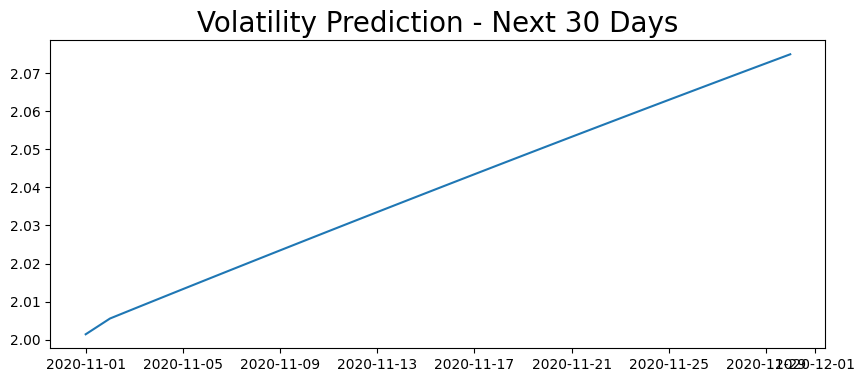

In [21]:
plt.figure(figsize=(10,4))
plt.plot(predic)
plt.title('Volatility Prediction - Next 30 Days', fontsize=20);

El modelo GARCH predice que a lo largo de noviembre 2020 la volatilidad subira de forma constante. Tambien se puede observar, que el unico valor que cambia la pendiente es el del segundo dia. A partir de ahi, como el modelo solo predice en base a un retardo, la pendiente es constante. <br>

Por eso, como alternativa al modelo, podemos calcular la volatilidad cada dia con lo precios disponibles hata ese dia, de este modo no solo obtenemos una mayor granularidad, si no que tambien podemos comparar la volatilidad predicha con la volatilidad historica.

Para hacer esto, lo primero que haremos es calculaer con nuestro modelo GARCH la volatilidad de cada dia para los ultimos 2 años de forma "rolling" y graficarla con los retornos:

In [22]:
returns = 100*dataBMWall['log_ret'].dropna()

In [23]:
import warnings
warnings.filterwarnings('ignore')

rolling_predictions = []
test_size = 365*2

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = ARX(train, lags=[1])
    model.volatility = GARCH(p=1,q=1)
    model.distribution = StudentsT()
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    


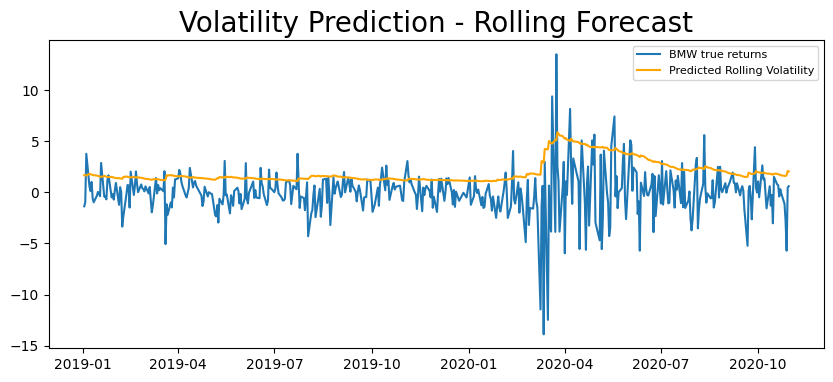

In [24]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-test_size:])
plt.figure(figsize=(10,4))
true, = plt.plot(returns["2019":"2020-10-31"])
preds, = plt.plot(rolling_predictions["2019":"2020-10-31"], "orange")
# preds2, = plt.plot(rolling_predictions["2020-10-31":])
# predss, = plt.plot(predic)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(["BMW true returns",'Predicted Rolling Volatility'], fontsize=8);

Podemos observar que la volatilidad (un valor siempre positivo) se va ajustnado por encima de las rentabilides dia a dia, reflejando asi periodos de mas y menos volatilidad. Con estos datos podemos evitar graficar los retornos para poder comparar las volatilidades de forma mas clara.

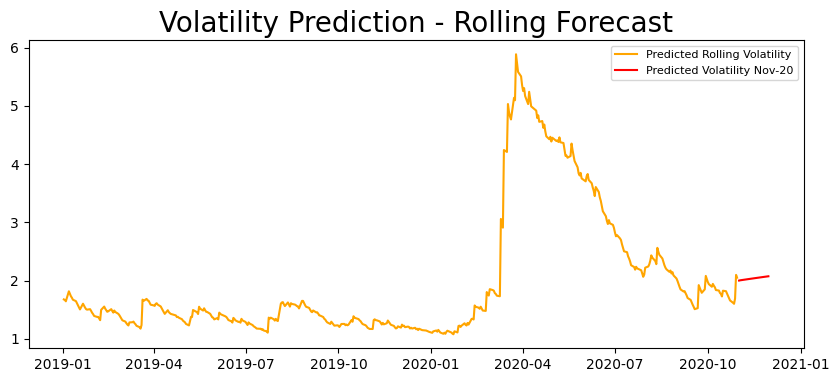

In [50]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-test_size:])
plt.figure(figsize=(10,4))
# true, = plt.plot(returns["2019":"2020-10-31"])
preds, = plt.plot(rolling_predictions["2019":"2020-10-31"], "orange")
# preds2, = plt.plot(rolling_predictions["2020-10-31":])
predss, = plt.plot(predic, 'red')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['Predicted Rolling Volatility', 'Predicted Volatility Nov-20'], fontsize=8);

Quitando del grafico las rentabilidades y añadiendo las predicciones podemos interpretarlas de mejor forma. Podemos ver que la volatilidad esperada va a incrementar, pero en terminos relativos no sera tan alta como durante el Covid por ejemplo. Para enriquecer este analisis, podemos  calcular la volatilidad cada dia de noviembre con lo precios disponibles hata ese dia y obtenemos:

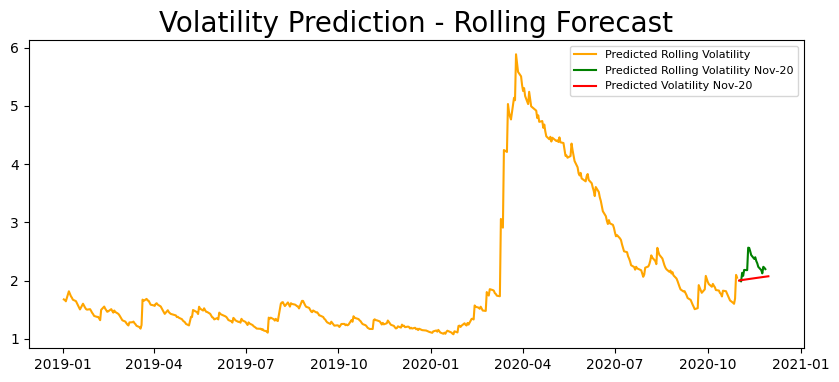

In [51]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-test_size:])
plt.figure(figsize=(10,4))
# true, = plt.plot(returns["2019":"2020-10-31"])
preds, = plt.plot(rolling_predictions["2019":"2020-10-31"], "orange")
preds2, = plt.plot(rolling_predictions["2020-10-31":], "green")
predss, = plt.plot(predic, 'red')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['Predicted Rolling Volatility', 'Predicted Rolling Volatility Nov-20','Predicted Volatility Nov-20'], fontsize=8);

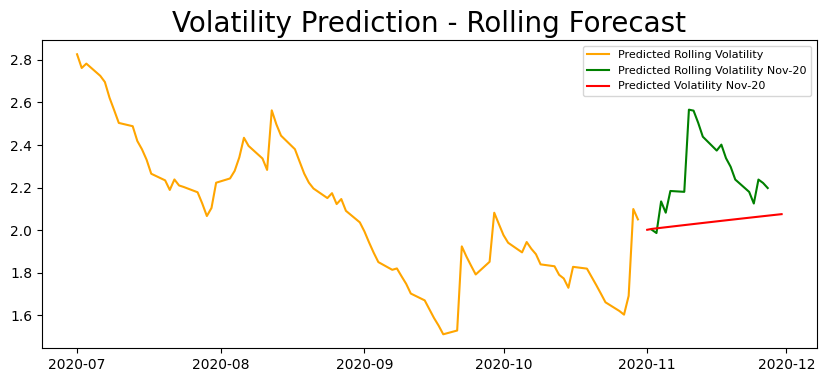

In [54]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-test_size:])
plt.figure(figsize=(10,4))
# true, = plt.plot(returns["2019":"2020-10-31"])
preds, = plt.plot(rolling_predictions["2020-07-01":"2020-10-31"], "orange")
preds2, = plt.plot(rolling_predictions["2020-10-31":], "green")
predss, = plt.plot(predic, 'red')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['Predicted Rolling Volatility', 'Predicted Rolling Volatility Nov-20','Predicted Volatility Nov-20'], fontsize=8);

De esta manera vemos como el modelo GARCH a un mes vista ha sido capaz de predecir la tendencia de la volatilidad para el mes de noviembre, pero no los shocks en volatilidad intra mensuales que se reflejan si predecimos cada volatilidad con un GARCH con los valores hasta el dia t-1. 

En **conclusion**, creo que las predicciones del modelo GARCH para un mes vista son todo lo buenas posibles ya que encuentra la tendencia de la volatilidad, pero pienso que lo mejor es hacerlo de forma rolling ya que aunque solo sea a un dia vista, el cumulo de predicciones es mas preciso, pero la prediccion mensual es un buen proxy.

#  6. Plantea un sistema de trading diario para BMW a partir del modelo Garch para el mes de noviembre de 2020. ¿Es rentable?

Si tuviera que hacer una eleccion de inversion el dia 1 de Noviembre en base a la prediccion de todo el mes (la linea roja en el grafico anterior) diria que lo mejor es ir **largo** para todo el mes. Es decir comprar  acciones de BMW el 1 y venderlar el 30. Ya que como inversor "risk lover", pienso que si la volatilidad va a incrementar a lo largo del mes, especialmente en este periodo de desecalada del Covid,  me merece la pena someterme a un riesgo creciente si ademas espero que el precio de la accion suba.

Por otro lado, debido a que la practica de trading se hace de forma diaria, creo que la mejor forma de crear un sistema de trading es usando las predicciones diarias de la volatilidad calculadas en el ejercicio anterior (la linea verde):
Viendo que la predicion de la volatilidad es mu creciente hasta el dia 11 de noviembre que es el maximo, mi estrategia seria ir comprando cada dia o comprar el primer dia y mantener cada dia hasta que el modelo deje de predecir un aumento en volatilidad para el dia sigiente. En el momento en el que la volatilidad baje podre vender mis acciones e inverir ese dinero en compañias con mayor volatilidad ya que si mantengo en BMW pero con poca volatilidad, el retorno marginal sera mucho menor. <br> <br>

Graficamos el precio de las acciones de BMW para este periodo:

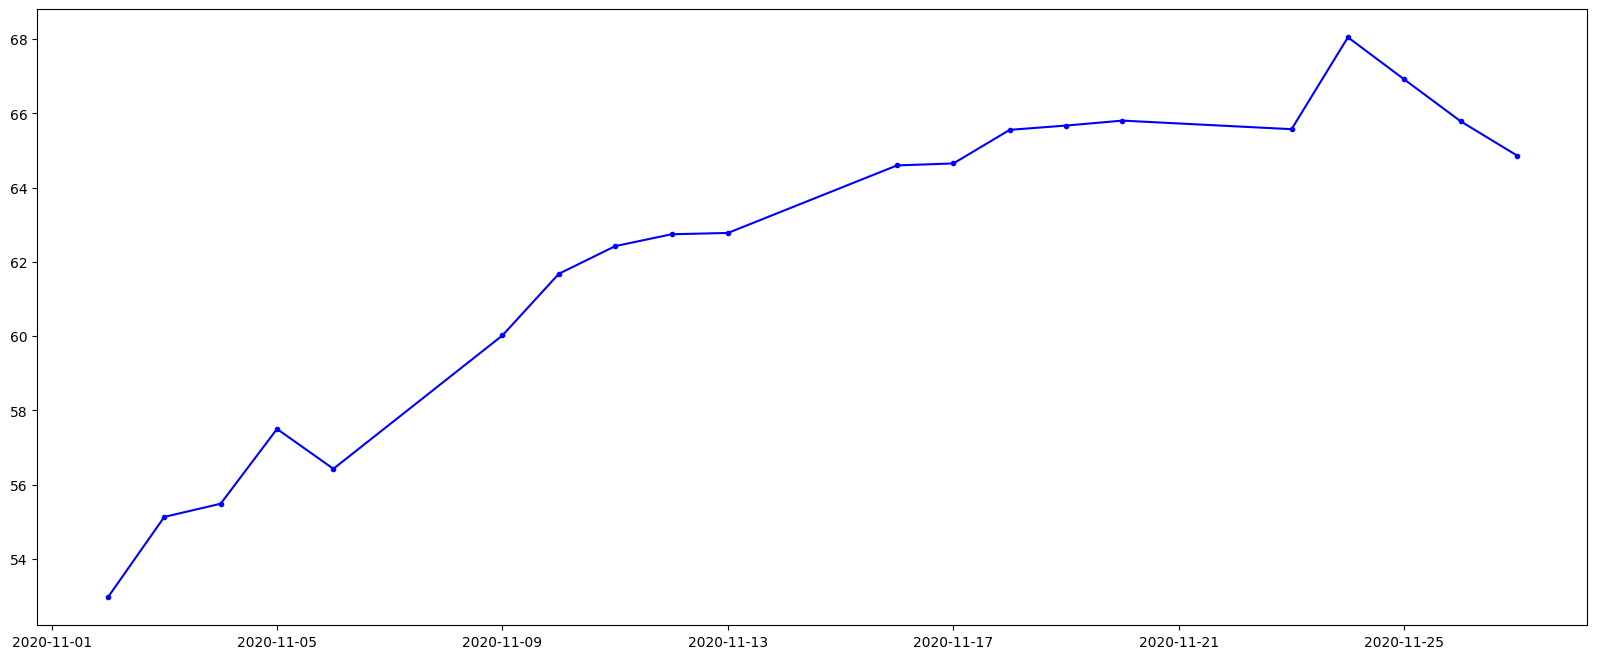

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(dataBMWall["Price"]["2020-11-01":],"blue", label = "BMW closing price", marker = ".");

**Conclusion**
Vemos que durante todo el mes, el precio de la accion de BMW ha subido de forma consisente, exceptand los ultimos tres dias. De este modo ambas estrategias de largo en la accion son rentables. <br>
Cabe destacar, que como comentaba la segunda estrategia, la mayor parte de la rentabilidad del mes se obtiene hasta el 11 de noviembre donde la curva se aplana. Esta segunda estrategia nos permitiria sacar la mayor rentabilidad en el menor tiempo y asi poder vender y comprar otra accion. 


La rentabilidad total y por cada dia de apertura de mercado de cada estrategia sería:

In [49]:
rent30 = (dataBMWall["Price"]["2020-11-27"]/dataBMWall["Price"]["2020-11-02"]) - 1
dias30 = dataBMWall["Price"]["2020-11-02":].count()
rent11 = (dataBMWall["Price"]["2020-11-11"]/dataBMWall["Price"]["2020-11-02"]) - 1
dias11 = dataBMWall["Price"]["2020-11-02":"2020-11-11"].count()
print(f"La rentabilidad total para todo el mes es de {round(rent30*100,2)}%, que por cada dia de trading es {round(rent30/dias30*100,2)}%")
print(f"La rentabilidad total vendiendo el 11 de noviembre es de {round(rent11*100,2)}%, que por cada dia de trading es {round(rent11/dias11*100,2)}%")

La rentabilidad total para todo el mes es de 22.47%, que por cada dia de trading es 1.12%
La rentabilidad total vendiendo el 11 de noviembre es de 17.86%, que por cada dia de trading es 2.23%


Aunque la rentabilidad total de la primera estrategia es mayor, la rentabilidad por dia de vender el 11 de noviembre es del doble que de la anterior, ya que en menos de la mitad de dias se consigue captar casi toda la rentabilidad del mes.

In [51]:
!jupyter-nbconvert HM02_JuanSevillaFernandez.ipynb --no-input --no-prompt --to html
warnings.filterwarnings("ignore")

[NbConvertApp] Converting notebook HM02_JuanSevillaFernandez.ipynb to html
[NbConvertApp] Writing 1646860 bytes to HM02_JuanSevillaFernandez.html
